## Fahrzeug Positionsbestimmung bei Linearer Bewegung

### Annahmen für das Versuch

Wir fahren mit konstanter Geschwindigkeit. Die Geschwindigkeit kann mittels der Radgeschwindigkeit ermittelt werden.

In [2]:
using LinearAlgebra, Plots, DataFrames, Distributions, CSV, Dates, GLM
gr()
upscale = 1
default(line = (:steppre, 0.5, 1, 2), size=(800*upscale,600*upscale))

### Zustandsvektoren

$$
    x_k = 
    \begin{pmatrix}
    x \\ y \\ \dot x \\ \dot y \\ \ddot x \\ \ddot y
    \end{pmatrix}
    = 
    \begin{pmatrix}
    X Position & Y Position & v_x & v_y & acc_x & acc_y
    \end{pmatrix}
$$


Mit Formeln aus Physik ergibt die Gleichung $ x_{k+1} = Ax_k$:


$$
    x_{k+1} = 
    \begin{pmatrix}
    1 & 0 & \Delta t & 0 & \frac{1}{2}\Delta t^2 & 0 \\
    0 & 1 & 0 & \Delta t & 0 & \frac{1}{2}\Delta t^2 \\
    0 & 0 & 1 & 0 & \Delta t & 0 \\
    0 & 0 & 0 & 1 & 0 & \Delta t \\
    0 & 0 & 0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 0 & 0 & 1
    \end{pmatrix}
    \begin{pmatrix}
    x \\ y \\ \dot x \\ \dot y \\ \ddot x \\ \ddot y
    \end{pmatrix}
$$

Unsere Beobachtungsmodell ist $ y = Gx $:

$$
    y =
    \begin{pmatrix}
    0 & 0 & 0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 0 & 0  & 1
    \end{pmatrix}
    *
    x
$$
Das bedeutet wir beobachten die Geschwindigkeit in der richtigen Einheit.

### Startzustand $x_0$

$$
    x_0 =
    \begin{pmatrix}
    0 \\
    0 \\
    0 \\
    0 \\
    0 \\
    0
    \end{pmatrix}
$$

mit

$$
    \Sigma_0 = 
    \begin{pmatrix}
    \sigma _{x}^2 & 0 & 0 & 0 & 0 & 0 \\
    0 & \sigma _{y}^2 & 0 & 0 & 0 & 0 \\
    0 & 0 & \sigma _{\dot x}^2 & 0  & 0 & 0\\
    0 & 0 & 0 & \sigma _{\dot y}^2 & 0 & 0 \\
    0 & 0 & 0 & 0 & \sigma _{\ddot y}^2 & 0 \\
    0 & 0 & 0 & 0 & 0 & \sigma _{\ddot x}^2 
    \end{pmatrix}
$$

ist der Unsicherheitsmatrix (Kovarianzmatrix) in Schritt $k = 0$ mit $\sigma$ Standardabweichung.

In [3]:
x_0 = zeros(6, 1)
Σ_0 = Matrix{Float64}(I, 6, 6) .* 1000

6×6 Array{Float64,2}:
 1000.0     0.0     0.0     0.0     0.0     0.0
    0.0  1000.0     0.0     0.0     0.0     0.0
    0.0     0.0  1000.0     0.0     0.0     0.0
    0.0     0.0     0.0  1000.0     0.0     0.0
    0.0     0.0     0.0     0.0  1000.0     0.0
    0.0     0.0     0.0     0.0     0.0  1000.0

### Zustandsübergangsmatrix $A$

In [4]:
Δ_t = 0.1 # Messfrequenz war 100ms
A = [1 0 Δ_t 0 0.5*Δ_t^2 0;
     0 1 0 Δ_t 0 0.5*Δ_t^2;
     0 0 1 0 Δ_t 0;
     0 0 0 1 0 Δ_t;
     0 0 0 0 1 0;
     0 0 0 0 0 1]

6×6 Array{Float64,2}:
 1.0  0.0  0.1  0.0  0.005  0.0  
 0.0  1.0  0.0  0.1  0.0    0.005
 0.0  0.0  1.0  0.0  0.1    0.0  
 0.0  0.0  0.0  1.0  0.0    0.1  
 0.0  0.0  0.0  0.0  1.0    0.0  
 0.0  0.0  0.0  0.0  0.0    1.0  

### Messmatrix $ G $

Wir messen nur $\ddot x$ und $\ddot y$ direkt.

In [5]:
G = [0 0 0 0 1 0;
     0 0 0 0 0 1]


2×6 Array{Int64,2}:
 0  0  0  0  1  0
 0  0  0  0  0  1

### Messrauschen Kovarianz $R$

R zeigt, wie genau die Messung war.

$$
    R =
    \begin{pmatrix}
    \sigma_{\dot x}^2 & 0 \\
    0 & \sigma_{\dot y}^2
    \end{pmatrix}
$$

In [6]:
R = [0.1 0;
     0 0.1]

function preprocess(sensor) 
    for c = [:Gyro_x, :Gyro_y, :Gyro_z, :Accel_z]
        deletecols!(sensor, c)
    end
    sensor[:Id] = 0:size(sensor)[1]-1
    sensor.Accel_x = (sensor[:Accel_x] .- mean(sensor.Accel_x)) .* 2
    sensor.Accel_y = (sensor[:Accel_y] .- mean(sensor.Accel_y)) .* 2
end

preprocess (generic function with 1 method)

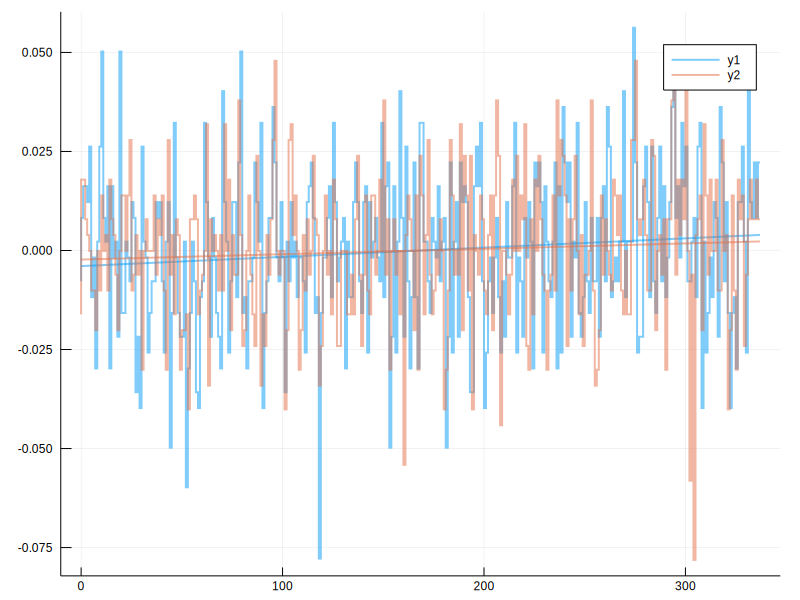

In [7]:
sensor_error = CSV.File("./sensor-error.csv", delim = ";", dateformat = DateFormat("yyyymmdd-HHMMss")) |> DataFrame
preprocess(sensor_error)
plot(sensor_error.Id, [sensor_error.Accel_x sensor_error.Accel_y], smooth = true)

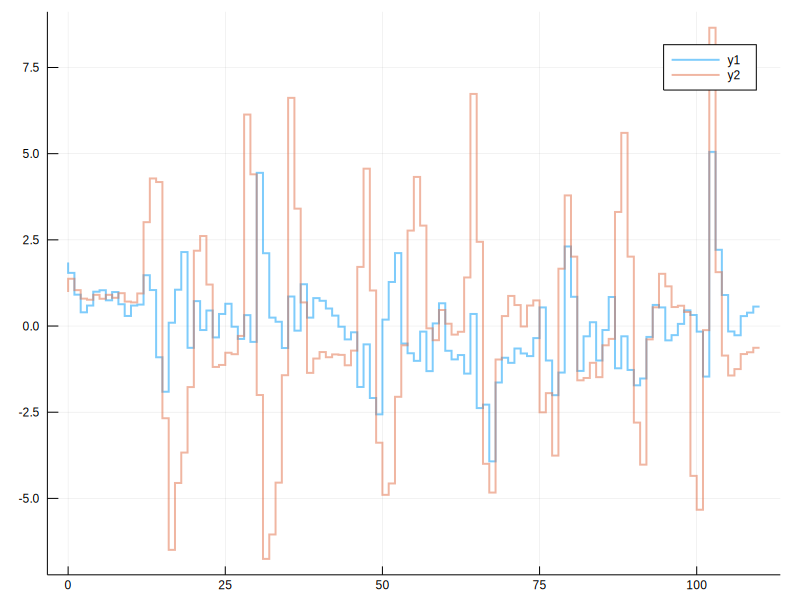

In [8]:
sensor_test = CSV.File("./sensor-test.csv", delim = ";", dateformat = DateFormat("yyyymmdd-HHMMss")) |> DataFrame
preprocess(sensor_test)
plot(sensor_test.Id, [sensor_test.Accel_x sensor_test.Accel_y])

In [9]:
data = vcat(sensor_error, sensor_test)
deletecols!(data, :Column8)
data[:Id] = 1:size(data)[1]
data

,Timestamp,Accel_x,Accel_y,Id
,DateTime⍰,Float64,Float64,Int64
1,2019-03-27T13:37:00.28,-0.00777515,-0.0161124,1
2,2019-03-27T13:37:00.28,0.00822485,0.0178876,2
3,2019-03-27T13:37:00.28,0.0162249,0.0178876,3
4,2019-03-27T13:37:00.28,0.0162249,0.00788757,4
5,2019-03-27T13:37:00.28,0.0122249,0.00388757,5
6,2019-03-27T13:37:00.28,0.0262249,-0.000112426,6
7,2019-03-27T13:37:00.28,-0.0117751,-0.0101124,7
8,2019-03-27T13:37:00.28,-0.00177515,-0.0101124,8
9,2019-03-27T13:37:00.28,-0.0297751,-0.0201124,9


### Prozessrauschen Kovarianzmatrix $Q$

Die Position des Fahrzeugs wird von äußeren Faktoren beeinflusst, wie z. B. der Wind oder rutschige Fahrbahn. Dies kann man mithilfe des Kovarianzmatrixes $Q$ modelliert werden.

$$
    Q = \begin{pmatrix}\sigma_{x}^2 & \sigma_{xy} & \sigma_{x \dot x} & \sigma_{x \dot y} \\ \sigma_{yx} & \sigma_{y}^2 & \sigma_{y \dot x} & \sigma_{y \dot y} \\ \sigma_{\dot x x} & \sigma_{\dot x y} & \sigma_{\dot x}^2 & \sigma_{\dot x \dot y} \\ \sigma_{\dot y x} & \sigma_{\dot y y} & \sigma_{\dot y \dot x} & \sigma_{\dot y}^2 \end{pmatrix}
$$

$Q$ kann berechnet werden als $ Q = G \cdot G^T \cdot \sigma_v^2$ mit 
$G = \begin{pmatrix}0.5dt^2 & 0.5dt^2 & dt & dt\end{pmatrix}^T$ und $\sigma_v$ als die Beschleunigungsprozessrauschen. Diese kann nach  Schubert, R., Adam, C., Obst, M., Mattern, N., Leonhardt, V., & Wanielik, G. (2011). Empirical evaluation of vehicular models for ego motion estimation als $8.8 m/s^2$ angenähert werden.

In [10]:
σ_v = 8.8
Gravity = transpose([ 0.5 * Δ_t^2 0.5 * Δ_t^2 Δ_t Δ_t Δ_t Δ_t])
#Q = Gravity * transpose(Gravity) * σ_v^2
Q = I * 0.2

UniformScaling{Float64}
0.2*I

### Messdaten
Im nächsten Schritt generieren wir messdaten.

In [11]:
n = size(data)[1]
x = data.Id

449-element Array{Int64,1}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
   ⋮
 438
 439
 440
 441
 442
 443
 444
 445
 446
 447
 448
 449

In [12]:
include("../KalmanFilter.jl")

Main.KalmanFilter

In [13]:
model = KalmanFilter.Kalman(A, Q, G, R, x_0, Σ_0)
y(i) = data[m_x[i]; m_y[i]]
predicted = zeros(Float64, 6, n)
fusioned = zeros(Float64, 6, n)
confidence = zeros(Float64, 4, 4, n)
gains = []
for i = eachrow(data)
    y_cur = [i.Accel_x; i.Accel_y]
    neu = KalmanFilter.next(model, y_cur)
    fusioned[:, i.Id] = neu.fusioned
    predicted[:, i.Id] = neu.predicted
    model = neu.model
end
output = DataFrame(fusioned', [:pX, :pY, :vX, :vY, :aX, :aY])
describe(output)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Nothing,DataType
1,pX,1.26427,-0.760853,-0.158252,10.3688,,,Float64
2,pY,0.435454,-0.460829,-0.0607725,3.61371,,,Float64
3,vX,0.199759,-0.832535,-0.0259426,2.54558,,,Float64
4,vY,0.0805766,-0.833066,-0.00921158,2.13254,,,Float64
5,aX,-0.000414318,-3.44778,1.65548e-6,3.40844,,,Float64
6,aY,0.000540434,-5.77231,0.000110751,5.97223,,,Float64


In [14]:
first(output, 6)

,pX,pY,vX,vY,aX,aY
,Float64,Float64,Float64,Float64,Float64,Float64
1,-3.88641e-5,-8.0538e-5,-0.000777282,-0.00161076,-0.00777437,-0.0161108
2,-7.5486e-5,-0.000152214,-0.000754897,-0.00152222,0.00422495,0.00938776
3,-8.58578e-5,-0.000226336,6.75647e-5,-0.000300136,0.0130249,0.015621
4,-4.8348e-6,-0.000200339,0.00146148,0.00104101,0.0153677,0.00995902
5,0.000210257,-6.16932e-5,0.00291254,0.00187133,0.013067,0.00551437
6,0.000598222,0.000139594,0.00457348,0.00227128,0.0226992,0.00139527


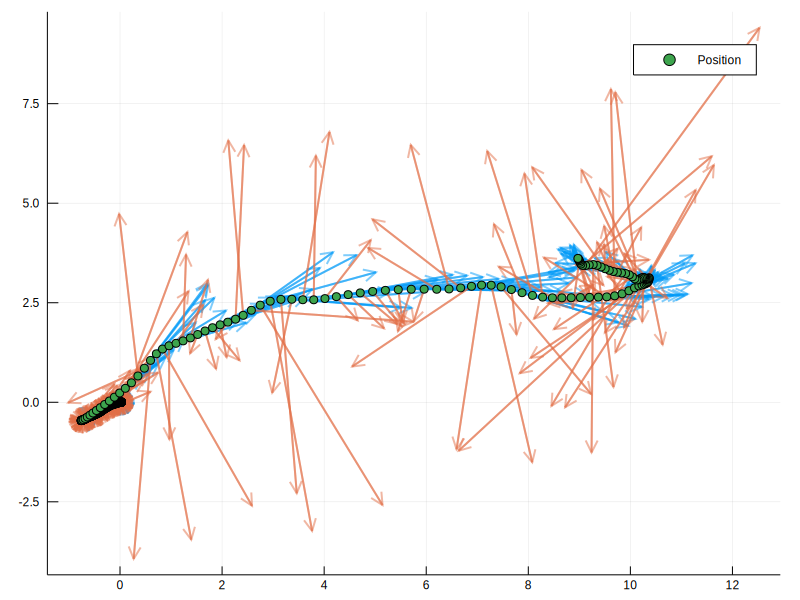

In [19]:
p = plot()
quiver!(output.pX, output.pY, quiver=(output.vX, output.vY), label = "Geschwindigkeit")
quiver!(output.pX, output.pY, quiver=(output.aX, output.aY))
scatter!(output.pX, output.pY, label = "Position")
png("plot-2d-motion.png")
p

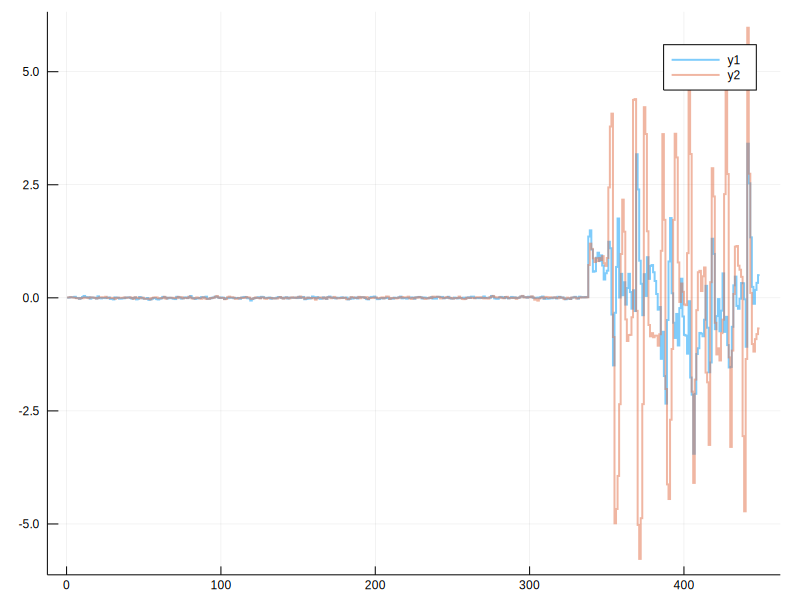

In [16]:
plot(x, [output.aX output.aY])

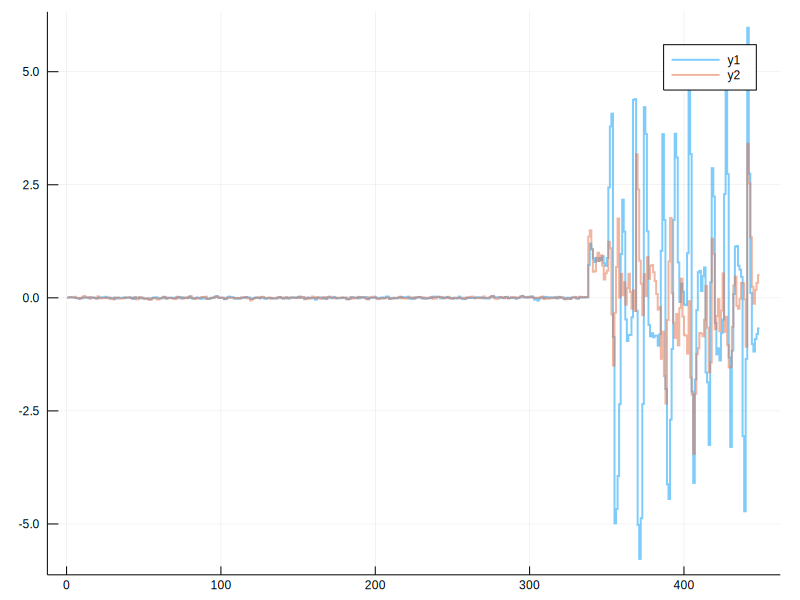

In [17]:
plot(x, [output.aY output.aX])